In [1]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F


In [3]:
# bs=32
# train = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
# test= MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=False)

In [205]:


bs=32*8*2
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=False)

In [206]:
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=bs, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=bs, shuffle=True)

In [207]:
dir(train)
train.targets


tensor([9, 0, 0,  ..., 3, 0, 5])

In [208]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [209]:
example_data.shape

torch.Size([512, 1, 28, 28])

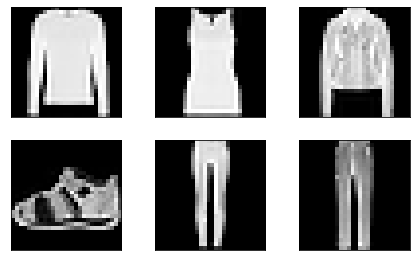

In [210]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

In [211]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device=torch.device('cpu')

In [212]:
torch.cuda.get_device_name()

'GeForce GTX 1050'

In [213]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [214]:
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1025):
        return input.view(input.size(0), size, 1, 1)

In [215]:
NNprint_=False;
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input

In [216]:

class VAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.ReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.ReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.ReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
        h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
        z = self.decode(z)
        return z, mu, logvar

In [217]:
image_channels = example_data.size(1)
image_channels

1

In [218]:
model = VAE(image_channels=image_channels,h_dim=1025,z_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [219]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [220]:
epochs=5

In [221]:
labels.size(0)

96

In [222]:
%%time
for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
#         print(idx)
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%500==0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                        epochs, loss.data.cpu().numpy().tolist()/bs, bce.data.cpu().numpy().tolist()/bs, kld.data.cpu().numpy().tolist()/bs)
            print(to_print)
torch.save(model.state_dict(), 'vae.torch')


Epoch[1/5] Loss: 538.330 538.330 0.000
Epoch[2/5] Loss: 253.551 253.535 0.016
Epoch[3/5] Loss: 244.618 244.599 0.019
Epoch[4/5] Loss: 232.896 232.877 0.019
Epoch[5/5] Loss: 245.056 245.040 0.016
Wall time: 1min 33s


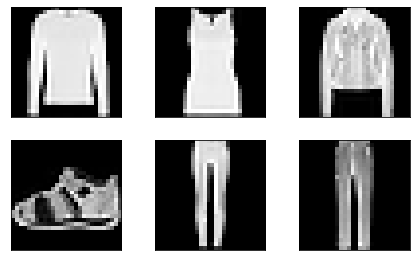

In [223]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

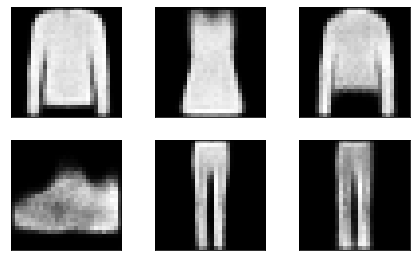

In [224]:
example_data_nn=model(example_data.to(device),example_targets)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data_nn[0][i][0].cpu().data, cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
example_data_nn=model(example_data.to(device))


In [ ]:
example_data_nn[0][i][0].shape